#Importing

In [19]:
import numpy as np
import cv2
from scipy.signal import argrelextrema
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt

In [2]:
from google.colab.patches import cv2_imshow

#Hough transform
for detecting straight kines we define hiugh transform function as below:
we change 'θ' from 0 to 180 degrees and for computing sin(θ) and cos(θ) we change it to radian using np.deg2rad function. Also, we compute the length of the image's digonal(D) and change 'ρ' from -D to +D.
Now we can build the accomulator matrix using these values. by sweeping through all the nonzero pixels of the input image(which is the result of the canny edge detection function) and calculating the 'ρ' of each 'θ' we can fill our accomulator matrix.

In [3]:
def hough(theta, rho, img, h, w):
  y, x = np.nonzero(img)
  l = len(y)
  rho_max = int(round(np.sqrt(h*h + w*w)))
  Rho = np.arange(-rho_max, rho_max, rho)
  Theta = np.deg2rad(np.arange(0, 180, theta))
  sin_t = np.sin(Theta)
  cos_t = np.cos(Theta)
  acc = np.zeros((len(Rho), len(Theta)))
  for i in range(l):
    for k in range(len(Theta)):
      r = int(round(x[i] * cos_t[k] + y[i] * sin_t[k])) + rho_max
      acc[r, k] += 1

  return acc, Rho, Theta


#running the algorithm_checker1:


##line detection

First of all, after loading the original image we transfer it to gray scale and after that for avoiding other unneccessary lines we blur the image. (for this purpose i tried different methods like opening, erosion and ... but due to the similarity of the lines some of them were still present, so here the gaussian filter with the written dimension gave me the best result). After bluring the image, we run a canny edge detection on image:

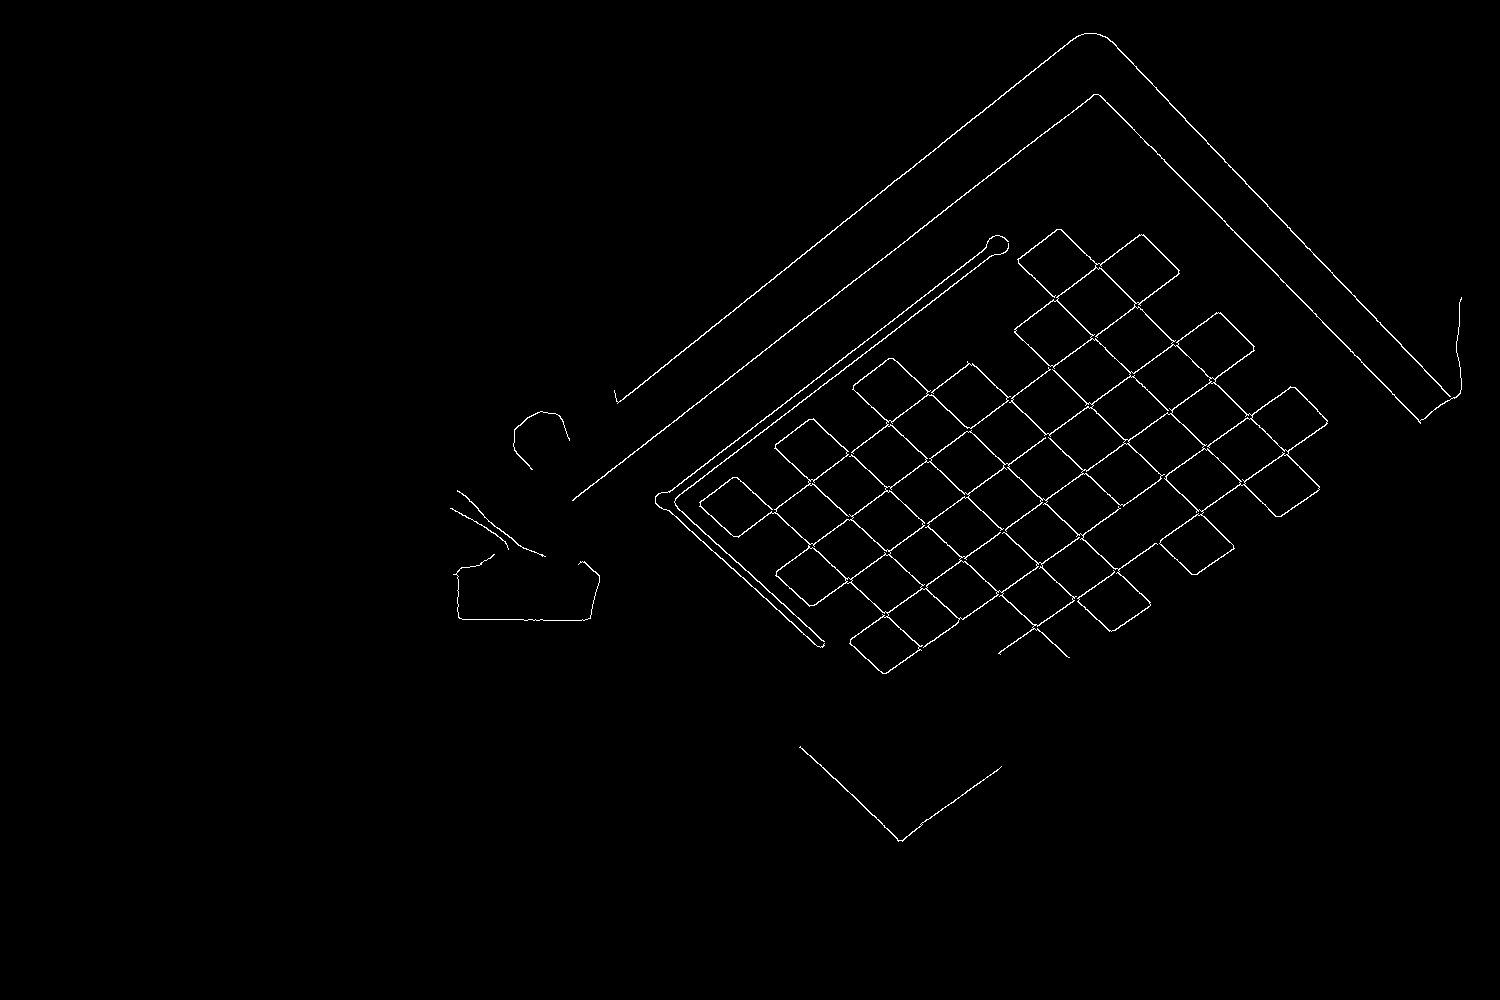

In [29]:
# read the input image
img = cv2.imread('/content/Checker1.jpg')

# convert the input image to grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#bluring the image:
blur = cv2.GaussianBlur(gray,(13,13),0)

# find the edges using Canny edge detector
edges = cv2.Canny(blur,50,200,apertureSize = 3)


cv2_imshow(edges)

we run the hough transform function and after that by using the peak_local_max function we sort the variables (higher votes come first). because we have the used ρ and θ vector, by having the peaks of accomulator matrix we can derive the related ρ and θ and draw their lines.

In [30]:
h, w = edges.shape
#running the hough transform
acc, Rho, Theta = hough(1, 1, edges, h, w)

#find the peals of accomulator matrix
loc = peak_local_max(acc)

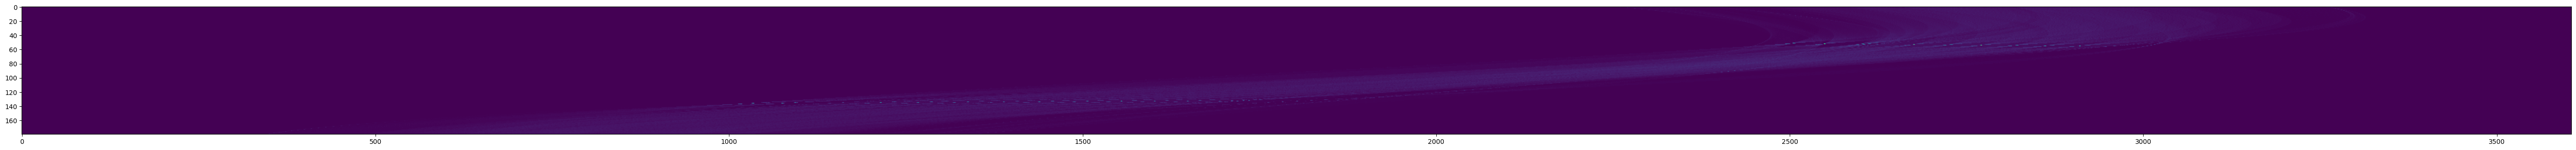

In [31]:
fig = plt.figure(figsize=(70, 40))
plt.imshow(acc.T)


Now we pick the first 30 locations and their related ρ and θ. with respect to these values we can compute 2 different point of each line:     

x0 = ρ * cos(θ)

y0 = ρ * sin(θ)

point 1 = (x0 - constant * sin(θ)  ,  y0 + constant * cos(θ))

point 2 = (x0 + constant * sin(θ)  ,  y0 - constant * cos(θ))

using point1 and point2 we have all the straight lines and we can draw them as below:

In [32]:
P1 = np.zeros((2, 30), dtype=int)
P2 = np.zeros((2, 30), dtype=int)
img = cv2.imread('/content/Checker1.jpg')
for i in range(30):
  theta = Theta[loc[i][1]]
  rho = Rho[loc[i][0]]
  x0 = rho*np.cos(theta)
  y0 = rho*np.sin(theta)
  P1[0, i], P1[1, i] = int(np.round(x0 + 1500*(-np.sin(theta)))), int(np.round(y0 + 1500*(np.cos(theta))))
  P2[0, i], P2[1, i] = int(np.round(x0 - 1500*(-np.sin(theta)))), int(np.round(y0 - 1500*(np.cos(theta))))
  cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)


In [33]:
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

For reducing the unneccessary lines even more, we compare the highest θ and ρ. as our desired lines are parallel in groups, the θ of them should be very close. we check this fact and drop the lines who dont meet this consentration:

In [34]:
#saving the max 30 rhos and thetas in arrys:
theta_line = np.zeros((1, 30))
rho_line = np.zeros((1, 30))
for i in range(30):
  theta_line[0, i] = Theta[loc[i][1]]
  rho_line[0, i] = Rho[loc[i][0]]

In [35]:
img = cv2.imread('/content/Checker1.jpg')
img1 = img.copy()
ind = []
for i in range(30):
  count = 0
  for j in range(30):
    if(theta_line[0, i]<= theta_line[0, j]+0.03 and theta_line[0, i]>= theta_line[0, j]-0.03):
      count += 1
  #print(str(i), ':', count)
  #droping unneccessary lines and redraw the lines:
  if((rho_line[0, i]>=0 and count>=6) or (rho_line[0, i]<=0 and count>=7)):
    img1 = cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)
    ind.append(i)


In [36]:
cv2_imshow(img1)

Output hidden; open in https://colab.research.google.com to view.

##intersection detection

now we should detect the intersection of detected lines, for this purpose we define the 'inter' function. in this function (x1, y1) and (x2, y2) belong to the first line and (x3, y3) and (x4, y4) belong to the second line. using the formulas define in this function we can compute the coordinates of 2 lines intersection. if the denomirator of this fraction is 0, the lines are parallel so we return 0 for both x and y.

In [15]:
def inter(x1, x2, x3, x4, y1, y2, y3, y4):
  a = (x1*y2 - y1*x2)*(x3 - x4) - (x1-x2)*(x3*y4 - y3*x4)
  b = (x1 - x2) * (y3 - y4) - (y1-y2)*(x3-x4)
  q = (x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4 - y3*x4)
  p = (x1 - x2) * (y3 - y4) - (y1-y2)*(x3-x4)
  Y = q/p
  X = a/b
  if (b == 0):
    X = 0
    Y = 0
  return X, Y

At last we calculate pairwise intersection using the function defined above. and we plot the result.

In [ ]:
X = []
Y = []
line1 = np.zeros((2, 2), dtype=int)
line2 = np.zeros((2, 2), dtype=int)
img = cv2.imread('/content/Checker1.jpg')
img1 = img.copy()
for I in range(len(ind)):
  i = ind[I]
  img1 = cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)
  for J in range(I+1, len(ind)):
    j = ind[J]
    x1 = P1[0, i]
    x2 = P2[0, i]
    y1 = P1[1, i]
    y2 = P2[1, i]

    x3 = P1[0, j]
    x4 = P2[0, j]
    y3 = P1[1, j]
    y4 = P2[1, j]
    x, y = inter(x1, x2, x3, x4, y1, y2, y3, y4)
    X.append(x)
    Y.append(y)
    img1 = cv2.line(img,(P1[0, j], P1[1, j]),(P2[0, j], P2[1, j]),(0,255,0),2)
    #img1 = cv2.circle(img1, (int(round(x)), int(round(y))), radius=2, color=(0, 0, 255), thickness=2)

for i in range(len(X)):
  img1 = cv2.circle(img1, (int(round(X[i])), int(round(Y[i]))), radius=2, color=(0, 0, 255), thickness=2)



<ipython-input-164-3714be0ca172>:6: RuntimeWarning: divide by zero encountered in long_scalars
  Y = q/p
<ipython-input-164-3714be0ca172>:7: RuntimeWarning: divide by zero encountered in long_scalars
  X = a/b


In [ ]:
cv2_imshow(img1)

Output hidden; open in https://colab.research.google.com to view.

#running the algorithm_checker2

##line detection

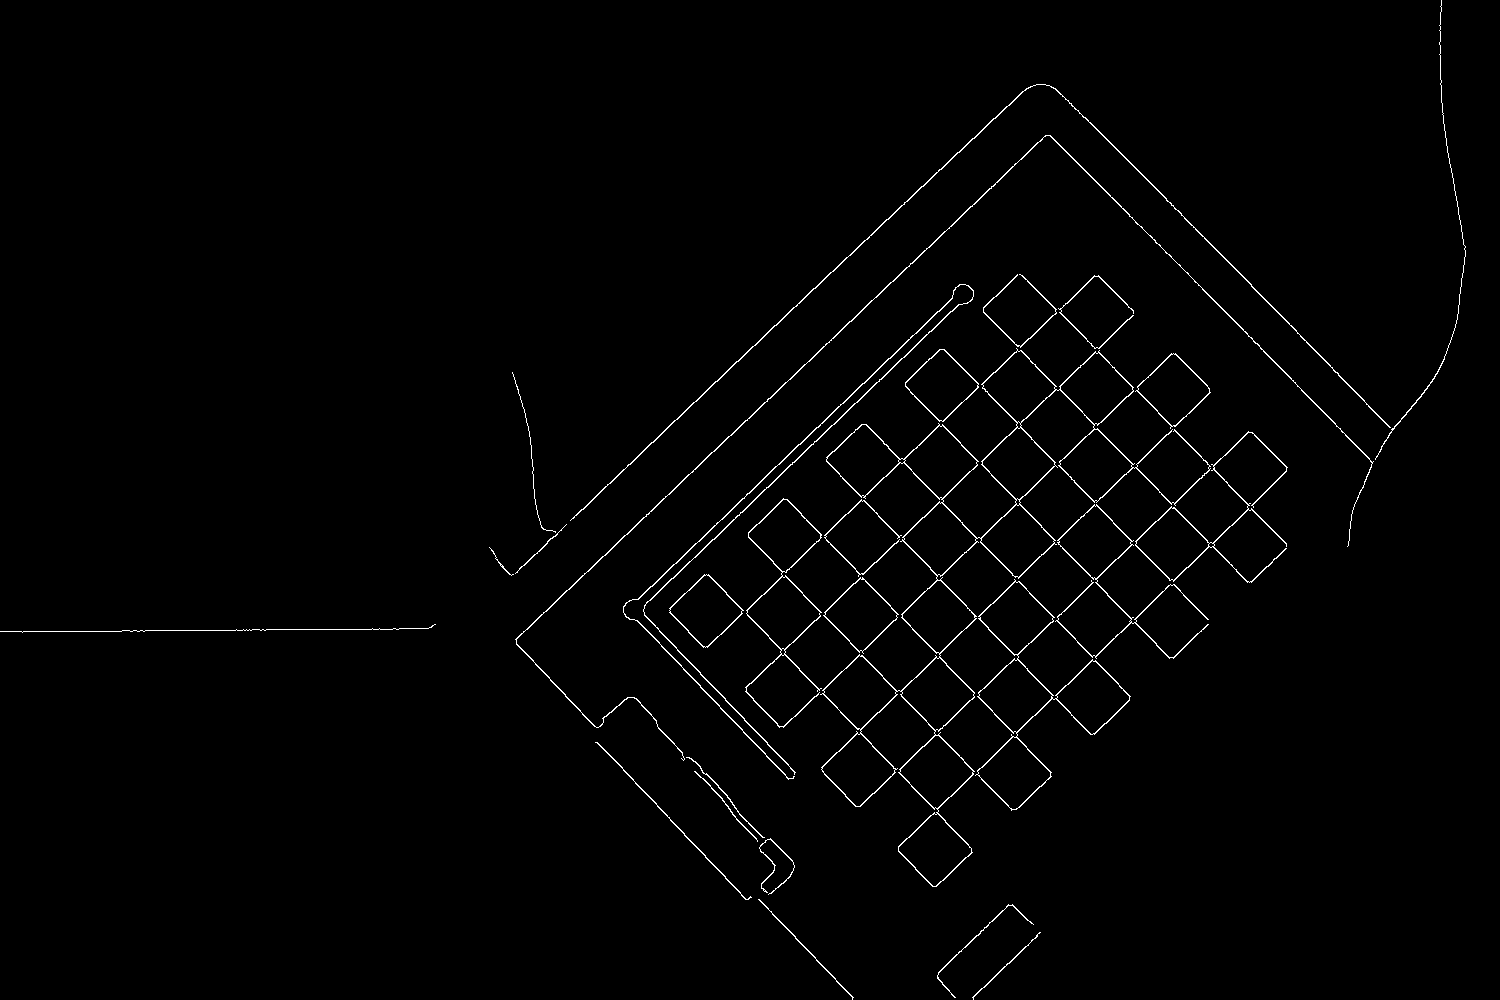

In [38]:
# read the input image
img = cv2.imread('/content/Checker2.jpg')

# convert the input image to grayscale image
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#bluring the image:
blur = cv2.GaussianBlur(gray,(13,13),0)

# find the edges using Canny edge detector
edges = cv2.Canny(blur,50,200,apertureSize = 3)


cv2_imshow(edges)

In [39]:
h, w = edges.shape
#running the hough transform
acc, Rho, Theta = hough(1, 1, edges, h, w)

#find the peals of accomulator matrix
loc = peak_local_max(acc)

we plot the accomulator marix as below.(you can zoom in the picture to see the result better.)

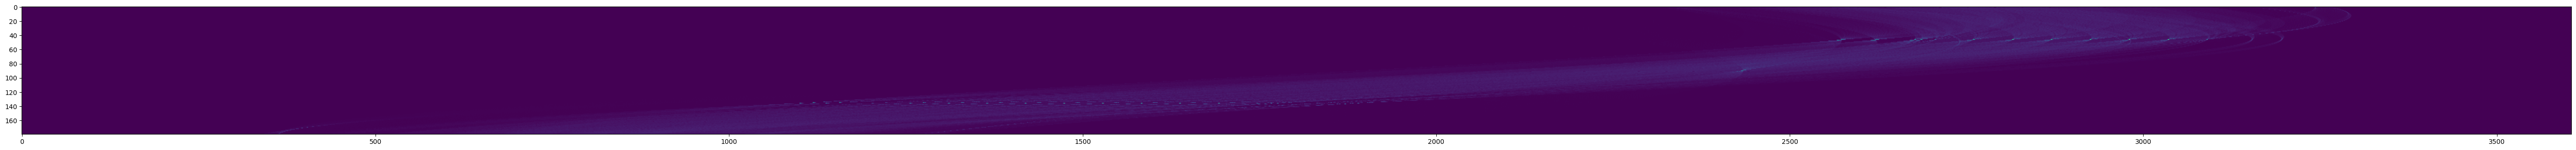

In [28]:
fig = plt.figure(figsize=(70, 40))
plt.imshow(acc.T)


In [40]:
P1 = np.zeros((2, 30), dtype=int)
P2 = np.zeros((2, 30), dtype=int)
img = cv2.imread('/content/Checker2.jpg')
for i in range(30):
  theta = Theta[loc[i][1]]
  rho = Rho[loc[i][0]]
  x0 = rho*np.cos(theta)
  y0 = rho*np.sin(theta)
  P1[0, i], P1[1, i] = int(np.round(x0 + 1500*(-np.sin(theta)))), int(np.round(y0 + 1500*(np.cos(theta))))
  P2[0, i], P2[1, i] = int(np.round(x0 - 1500*(-np.sin(theta)))), int(np.round(y0 - 1500*(np.cos(theta))))
  cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)

In [41]:
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [42]:
#saving the max 30 rhos and thetas in arrys:
theta_line = np.zeros((1, 30))
rho_line = np.zeros((1, 30))
for i in range(30):
  theta_line[0, i] = Theta[loc[i][1]]
  rho_line[0, i] = Rho[loc[i][0]]

In [43]:
img = cv2.imread('/content/Checker2.jpg')
img1 = img.copy()
ind = []
for i in range(30):
  count = 0
  for j in range(30):
    if(theta_line[0, i]<= theta_line[0, j]+0.03 and theta_line[0, i]>= theta_line[0, j]-0.03):
      count += 1
  #print(str(i), ':', count)
  #droping unneccessary lines and redraw the lines:
  if((rho_line[0, i]>=0 and count>=6) or (rho_line[0, i]<=0 and count>=7)):
    img1 = cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)
    ind.append(i)

In [44]:
cv2_imshow(img1)

Output hidden; open in https://colab.research.google.com to view.

##intersection detection

In [16]:
X = []
Y = []
line1 = np.zeros((2, 2), dtype=int)
line2 = np.zeros((2, 2), dtype=int)
img = cv2.imread('/content/Checker2.jpg')
img1 = img.copy()
for I in range(len(ind)):
  i = ind[I]
  img1 = cv2.line(img,(P1[0, i], P1[1, i]),(P2[0, i], P2[1, i]),(0,255,0),2)
  for J in range(I+1, len(ind)):
    j = ind[J]
    x1 = P1[0, i]
    x2 = P2[0, i]
    y1 = P1[1, i]
    y2 = P2[1, i]

    x3 = P1[0, j]
    x4 = P2[0, j]
    y3 = P1[1, j]
    y4 = P2[1, j]
    x, y = inter(x1, x2, x3, x4, y1, y2, y3, y4)
    X.append(x)
    Y.append(y)
    img1 = cv2.line(img,(P1[0, j], P1[1, j]),(P2[0, j], P2[1, j]),(0,255,0),2)
    #img1 = cv2.circle(img1, (int(round(x)), int(round(y))), radius=2, color=(0, 0, 255), thickness=2)

for i in range(len(X)):
  img1 = cv2.circle(img1, (int(round(X[i])), int(round(Y[i]))), radius=2, color=(0, 0, 255), thickness=2)

<ipython-input-15-3714be0ca172>:6: RuntimeWarning: divide by zero encountered in long_scalars
  Y = q/p
<ipython-input-15-3714be0ca172>:7: RuntimeWarning: divide by zero encountered in long_scalars
  X = a/b


In [17]:
cv2_imshow(img1)

Output hidden; open in https://colab.research.google.com to view.